# Kaggle competition restaurant visitor forecasting competition
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import umap
from sklearn.ensemble import IsolationForest

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [3]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [4]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
expanded_date_info = pd.read_csv('../../data_files/expanded_date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

## Merge data

In [5]:
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].apply(lambda x: x[:10])
# air_reserve['reserve_date'] = pd.to_datetime(air_reserve['reserve_date'])

In [6]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x: x[:10])
# air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])

In [7]:
air_reserve_daily = air_reserve[[
        'air_store_id',
        'visit_date',
        'reserve_visitors'
    ]].groupby(['air_store_id', 'visit_date'], as_index=False).agg('sum')

In [8]:
desc(air_reserve_daily)

air_store_id  visit_date  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                 2
1  air_00a91d42b08b08d9  2016-12-05                 9
2  air_00a91d42b08b08d9  2016-12-14                18
3  air_00a91d42b08b08d9  2016-12-17                 2
4  air_00a91d42b08b08d9  2016-12-20                 4

(29830, 3)
air_store_id        object
visit_date          object
reserve_visitors     int64
dtype: object


In [9]:
air_visit_data = pd.merge(
    left=air_visit_data,
    right=air_reserve_daily,
    on=['air_store_id', 'visit_date'],
    how='left',
    copy=False
)

In [10]:
# should we make a seperate column with binary for nullfill?
air_visit_data['reserve_visitors'].fillna(0, inplace=True)

In [11]:
desc(air_visit_data)

air_store_id  visit_date  visitors  reserve_visitors
0  air_ba937bf13d40fb24  2016-01-13        25               0.0
1  air_ba937bf13d40fb24  2016-01-14        32               0.0
2  air_ba937bf13d40fb24  2016-01-15        29               0.0
3  air_ba937bf13d40fb24  2016-01-16        22               0.0
4  air_ba937bf13d40fb24  2016-01-18         6               0.0

(252108, 4)
air_store_id         object
visit_date           object
visitors              int64
reserve_visitors    float64
dtype: object


In [12]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

# Holiday and weekend significance

In [18]:
expanded_date_info['calendar_date'] = pd.to_datetime(expanded_date_info['calendar_date'])

## Holiday significance

In [22]:
holiday_sig = pd.merge(
    left=air_visit_data,
    right=expanded_date_info.rename(columns={'calendar_date': 'visit_date'}),
    on='visit_date',
    how='left',
    copy=False
)

In [27]:
holiday_sig = holiday_sig[[
    'air_store_id',
    'holiday_flg',
    'visitors',
    'reserve_visitors'
]].groupby(['air_store_id', 'holiday_flg'], as_index=True).agg('mean').unstack()

In [38]:
holiday_sig.columns = ['_'.join(tpl) for tpl 
                       in list(zip(holiday_sig.columns.get_level_values(0),
                                   holiday_sig.columns.get_level_values(1).astype(str)))
                      ]

In [41]:
holiday_sig.reset_index(inplace=True)

In [44]:
holiday_sig['visitors_holi_diff'] = holiday_sig['visitors_1'] - holiday_sig['visitors_0']

In [45]:
holiday_sig['reserve_visitors_holi_diff'] = holiday_sig['reserve_visitors_1'] - holiday_sig['reserve_visitors_0']

In [48]:
holiday_sig['visitors_holi_ratio'] = holiday_sig['visitors_1'] / holiday_sig['visitors_0']

In [49]:
holiday_sig['reserve_visitors_holi_ratio'] = holiday_sig['reserve_visitors_1'] / holiday_sig['reserve_visitors_0']

In [51]:
holiday_sig.fillna(0, inplace=True)

In [52]:
holiday_sig.head()

air_store_id  visitors_0  visitors_1  reserve_visitors_0  \
0  air_00a91d42b08b08d9   25.991228   31.250000            0.307018   
1  air_0164b9927d20bcc3    9.314685    7.666667            3.377622   
2  air_0241aa3964b7f861    9.903743    9.772727            0.000000   
3  air_0328696196e46f18    7.953704    7.750000            0.000000   
4  air_034a3d5b40d5b1b1   14.879310   14.210526            0.379310   

   reserve_visitors_1  visitors_holi_diff  reserve_visitors_holi_diff  \
0            0.000000            5.258772                   -0.307018   
1            0.833333           -1.648019                   -2.544289   
2            0.000000           -0.131016                    0.000000   
3            0.000000           -0.203704                    0.000000   
4            0.263158           -0.668784                   -0.116152   

   visitors_holi_ratio  reserve_visitors_holi_ratio  
0             1.202329                     0.000000  
1             0.823073                     0.246722  
2             0.986771                     0.000000  
3             0.974389                     0.000000  
4             0.955053                     0.693780

## Weekend significance

In [64]:
weekend_sig = pd.merge(
    left=air_visit_data,
    right=expanded_date_info.rename(columns={'calendar_date': 'visit_date'}),
    on='visit_date',
    how='left',
    copy=False
)

In [67]:
weekend_sig['weekend_flag'] = weekend_sig['day_of_week'].apply(lambda dow: 1 if dow in ['Saturday', 'Sunday'] else 0)

In [69]:
weekend_sig = weekend_sig[[
    'air_store_id',
    'weekend_flag',
    'visitors',
    'reserve_visitors'
]].groupby(['air_store_id', 'weekend_flag'], as_index=True).agg('mean').unstack()

In [73]:
weekend_sig.columns = ['_'.join(tpl) for tpl 
                       in list(zip(weekend_sig.columns.get_level_values(0),
                                   weekend_sig.columns.get_level_values(1).astype(str)))
                      ]

In [75]:
weekend_sig.reset_index(inplace=True)

In [77]:
weekend_sig['visitors_wknd_diff'] = weekend_sig['visitors_1'] - weekend_sig['visitors_0']

In [78]:
weekend_sig['reserve_visitors_wknd_diff'] = weekend_sig['reserve_visitors_1'] - weekend_sig['reserve_visitors_0']

In [79]:
weekend_sig['visitors_wknd_ratio'] = weekend_sig['visitors_1'] / weekend_sig['visitors_0']

In [80]:
weekend_sig['reserve_visitors_wknd_ratio'] = weekend_sig['reserve_visitors_1'] / weekend_sig['reserve_visitors_0']

In [82]:
weekend_sig.head()

air_store_id  visitors_0  visitors_1  reserve_visitors_0  \
0  air_00a91d42b08b08d9   28.393782   14.641026            0.305699   
1  air_0164b9927d20bcc3    9.740157    6.409091            3.622047   
2  air_0241aa3964b7f861    8.711610   12.348837            0.000000   
3  air_0328696196e46f18    7.378049    9.294118            0.000000   
4  air_034a3d5b40d5b1b1   13.300578   18.217949            0.098266   

   reserve_visitors_1  visitors_wknd_diff  reserve_visitors_wknd_diff  \
0            0.282051          -13.752757                   -0.023648   
1            1.272727           -3.331067                   -2.349320   
2            0.000000            3.637227                    0.000000   
3            0.000000            1.916069                    0.000000   
4            0.974359            4.917371                    0.876093   

   visitors_wknd_ratio  reserve_visitors_wknd_ratio  
0             0.515642                     0.922642  
1             0.658007                     0.351383  
2             1.417515                          NaN  
3             1.259699                          NaN  
4             1.369711                     9.915535

In [91]:
hw_sig = pd.merge(
    left=holiday_sig[[
        'air_store_id',
        'visitors_holi_diff',
        'reserve_visitors_holi_diff',
        'visitors_holi_ratio',
        'reserve_visitors_holi_ratio'
    ]],
    right=weekend_sig[[
        'air_store_id',
        'visitors_wknd_diff',
        'reserve_visitors_wknd_diff',
        'visitors_wknd_ratio',
        'reserve_visitors_wknd_ratio'
    ]],
    on='air_store_id',
    how='left',
    copy=False
)

In [93]:
hw_sig.fillna(0, inplace=True)

In [94]:
hw_sig.head()

air_store_id  visitors_holi_diff  reserve_visitors_holi_diff  \
0  air_00a91d42b08b08d9            5.258772                   -0.307018   
1  air_0164b9927d20bcc3           -1.648019                   -2.544289   
2  air_0241aa3964b7f861           -0.131016                    0.000000   
3  air_0328696196e46f18           -0.203704                    0.000000   
4  air_034a3d5b40d5b1b1           -0.668784                   -0.116152   

   visitors_holi_ratio  reserve_visitors_holi_ratio  visitors_wknd_diff  \
0             1.202329                     0.000000          -13.752757   
1             0.823073                     0.246722           -3.331067   
2             0.986771                     0.000000            3.637227   
3             0.974389                     0.000000            1.916069   
4             0.955053                     0.693780            4.917371   

   reserve_visitors_wknd_diff  visitors_wknd_ratio  \
0                   -0.023648             0.515642   
1                   -2.349320             0.658007   
2                    0.000000             1.417515   
3                    0.000000             1.259699   
4                    0.876093             1.369711   

   reserve_visitors_wknd_ratio  
0                     0.922642  
1                     0.351383  
2                     0.000000  
3                     0.000000  
4                     9.915535

### Data validation
There are some days where a restaurant will have more reserved visitors than actual visitors. This is not completely beyond the scope of reason, but there are occurrences of this that are very extreme. Some are shown below. We will attempt to remove the most extreme of these.

In [14]:
air_visit_data[
    air_visit_data['reserve_visitors'] > air_visit_data['visitors']
].sort_values('reserve_visitors', ascending=False).head(10)

air_store_id visit_date  visitors  reserve_visitors
17043   air_e7fbee4e3cfe65c5 2017-02-05        18            1633.0
17041   air_e7fbee4e3cfe65c5 2017-02-03        33             664.0
17042   air_e7fbee4e3cfe65c5 2017-02-04        56             641.0
17044   air_e7fbee4e3cfe65c5 2017-02-07        27             557.0
68051   air_465bddfed3353b23 2017-01-09        30             466.0
20993   air_b23d0f519291247d 2016-12-16       117             155.0
108738  air_a17f0778617c76e2 2017-03-16        17             142.0
71565   air_b439391e72899756 2017-02-23        11             104.0
154942  air_56cebcbd6906e04c 2017-03-19        67             104.0
180433  air_a083834e7ffe187e 2016-12-22        66              99.0

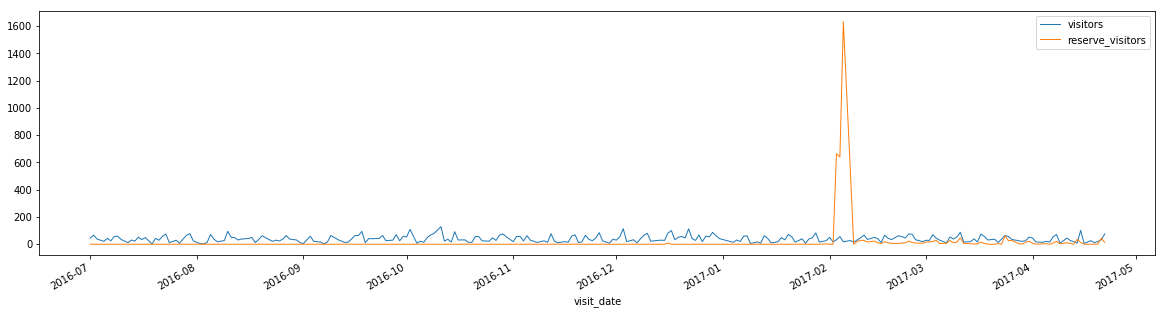

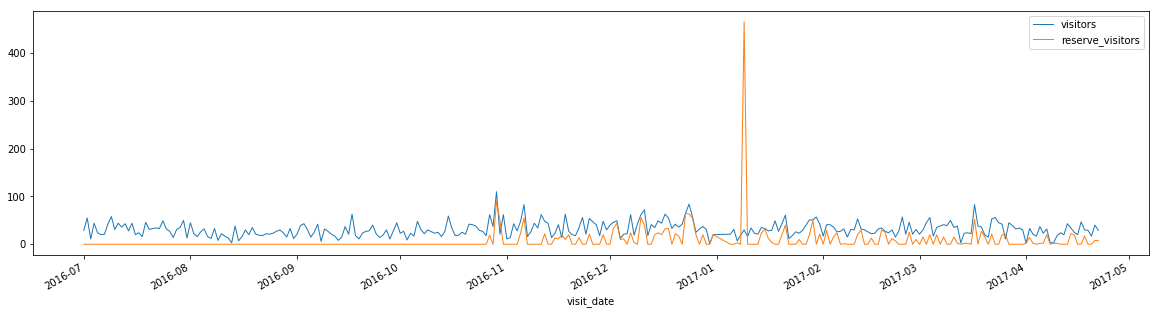

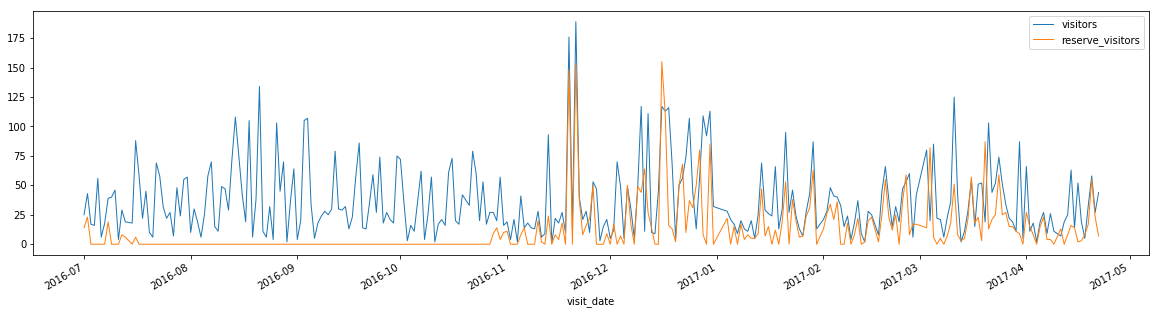

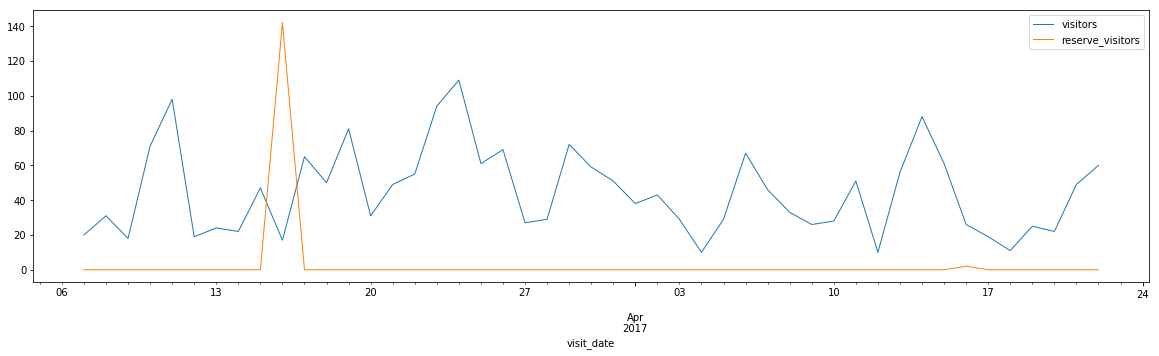

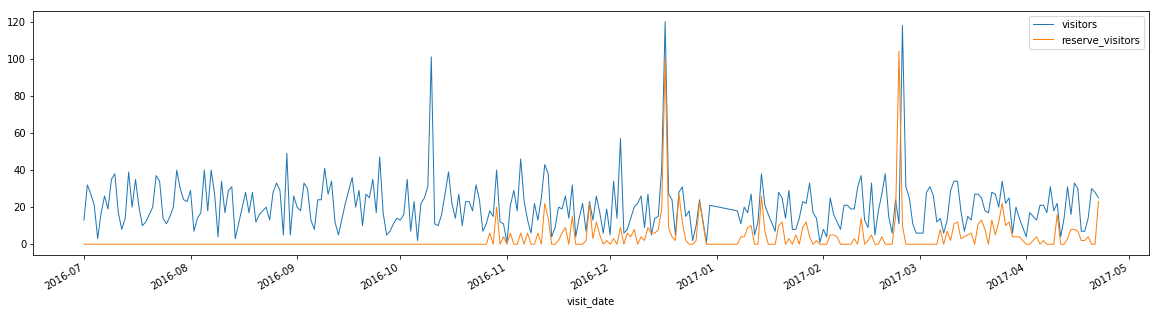

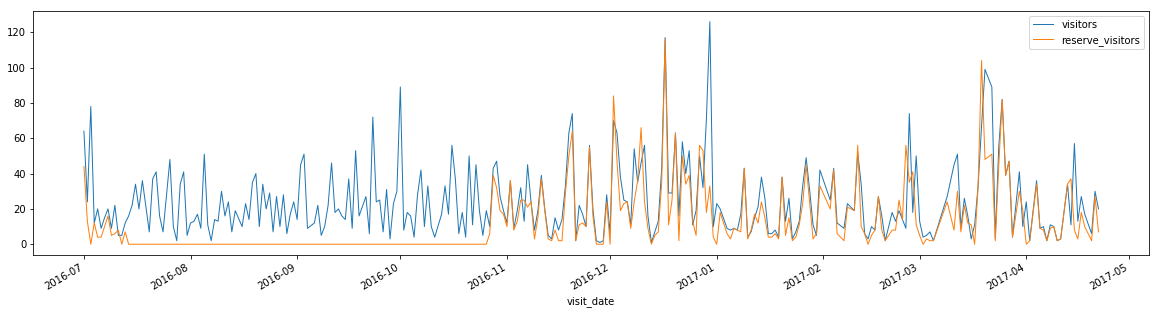

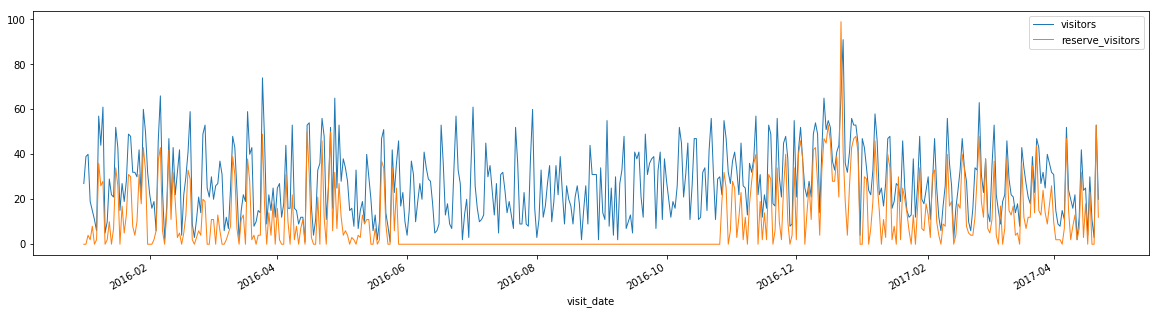

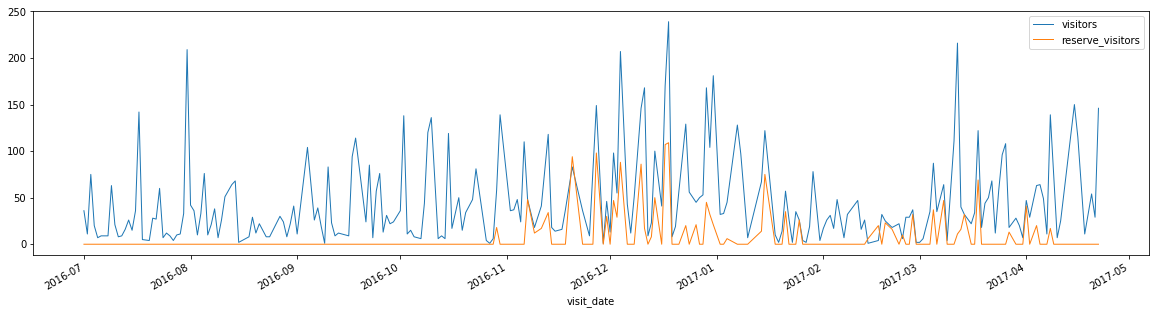

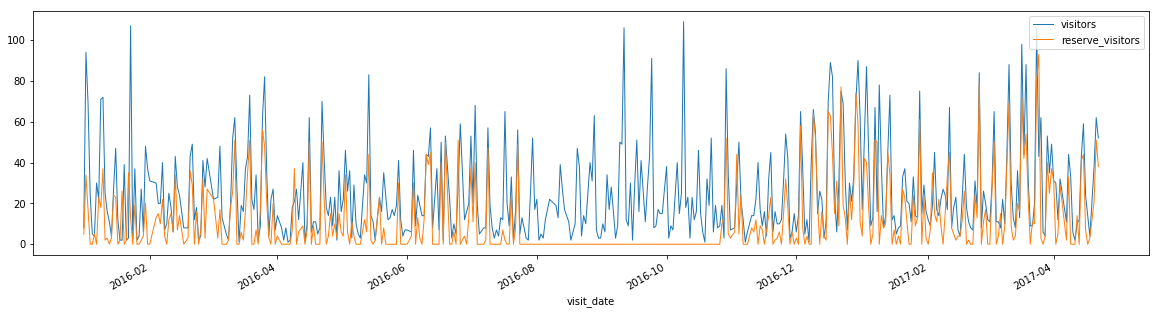

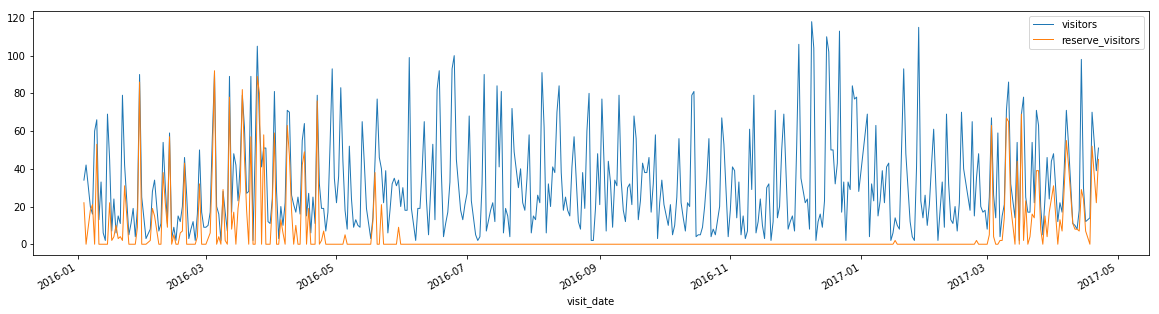

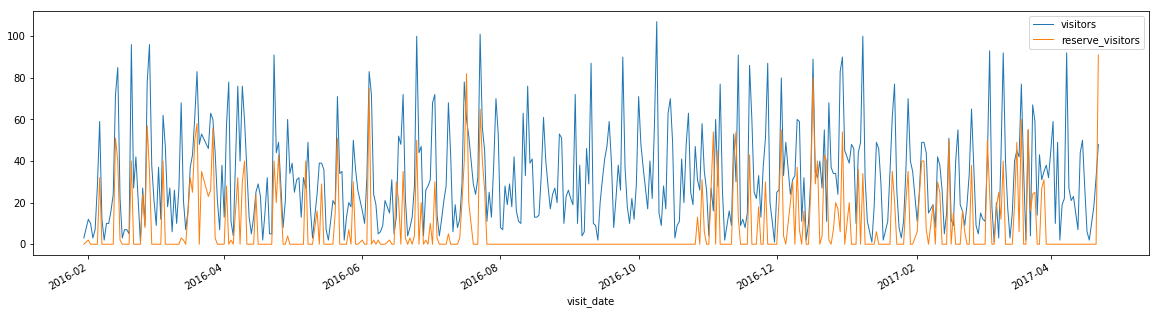

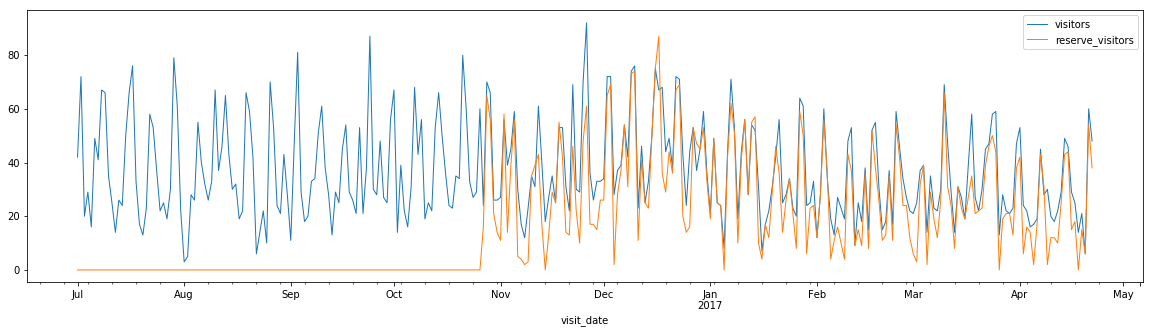

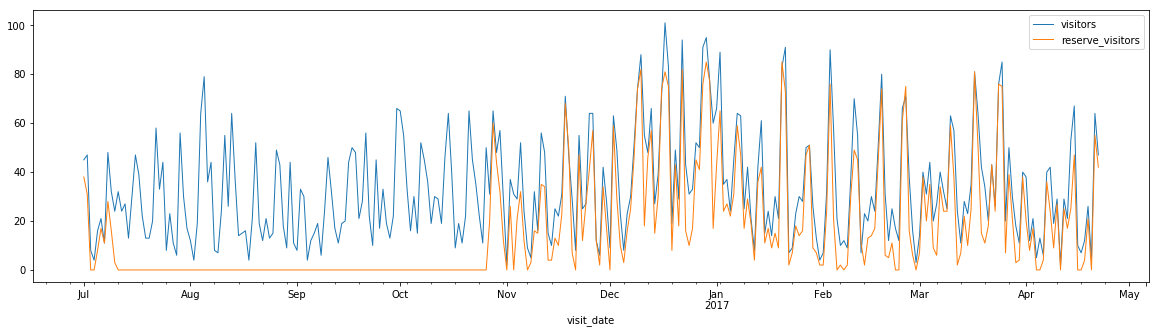

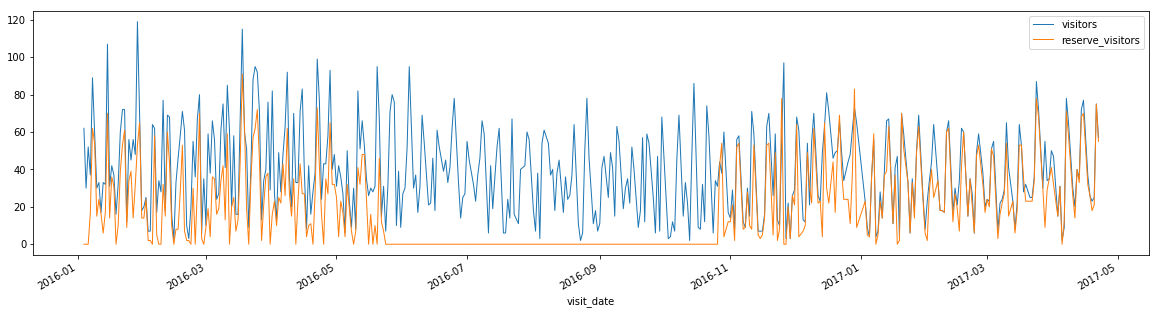

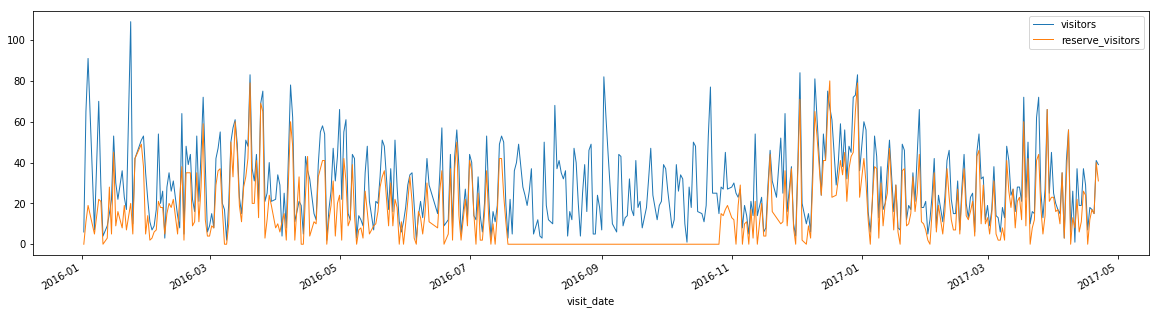

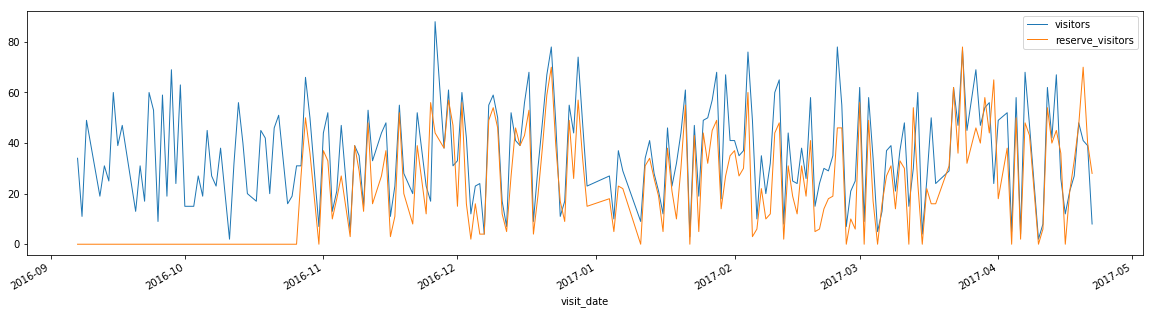

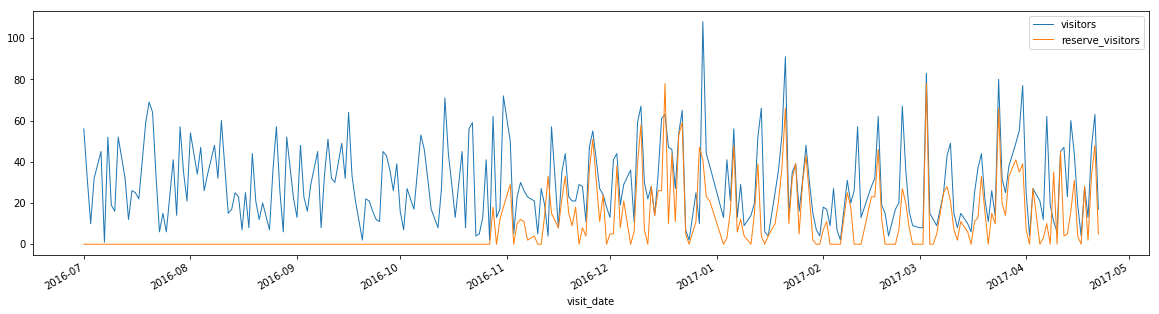

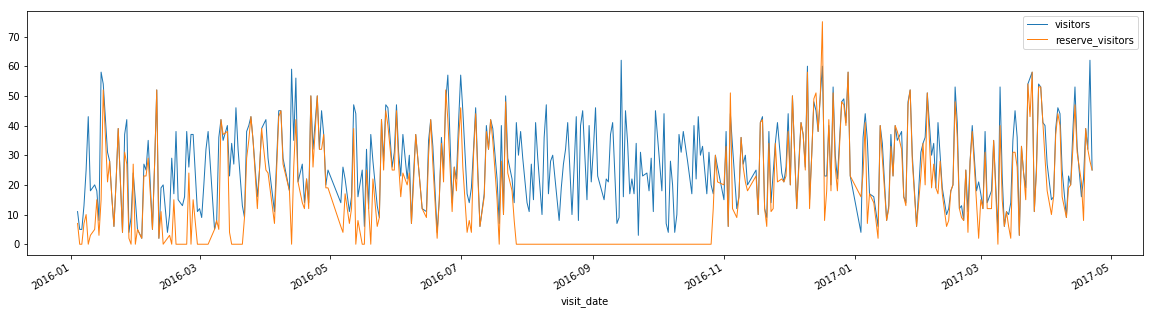

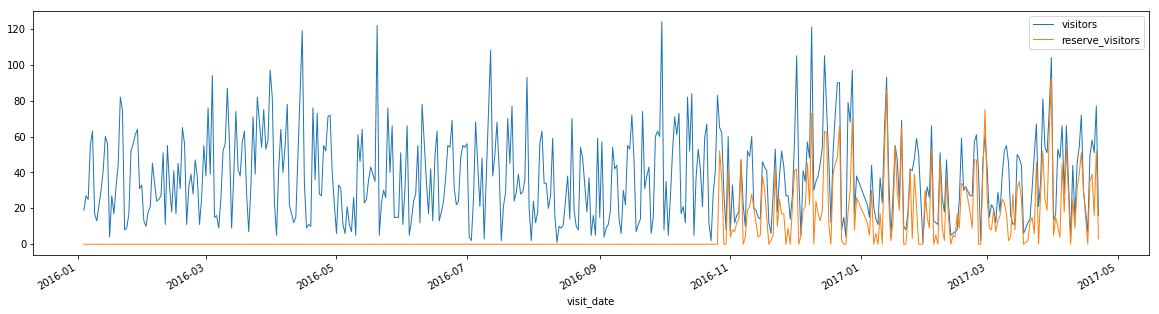

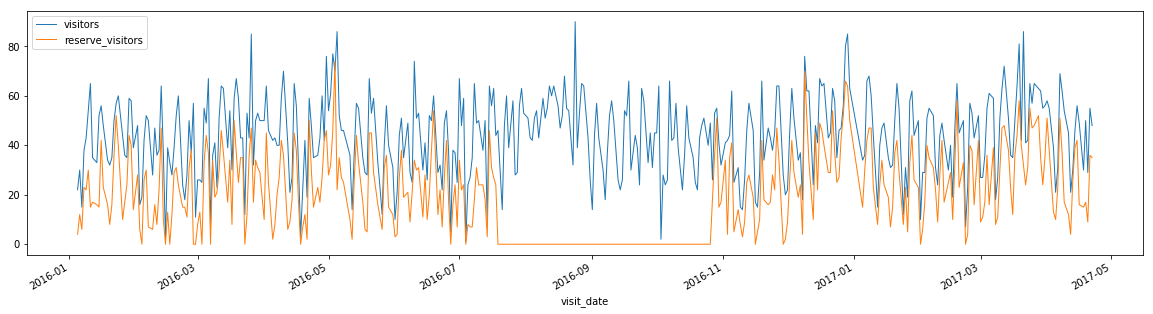

In [15]:
for location_id in air_visit_data[
        air_visit_data['reserve_visitors'] > air_visit_data['visitors']
    ].sort_values('reserve_visitors', ascending=False)['air_store_id'].unique()[:20]:
    air_visit_data[air_visit_data['air_store_id'] == location_id][[
        'visit_date',
        'visitors',
        'reserve_visitors'
    ]].plot(
        kind='line',
        lw=1,
        figsize=(20, 5),
        x='visit_date'
    );
    plt.show()

In [16]:
air_visit_location_max = air_visit_data[[
    'air_store_id',
    'visitors'
]].groupby('air_store_id').agg('max').to_dict()['visitors']

In [17]:
air_visit_data['reserve_visitors_corrected'] = \
air_visit_data.apply(lambda x: min(x['reserve_visitors'], 1.5*air_visit_location_max[x['air_store_id']]), axis=1)

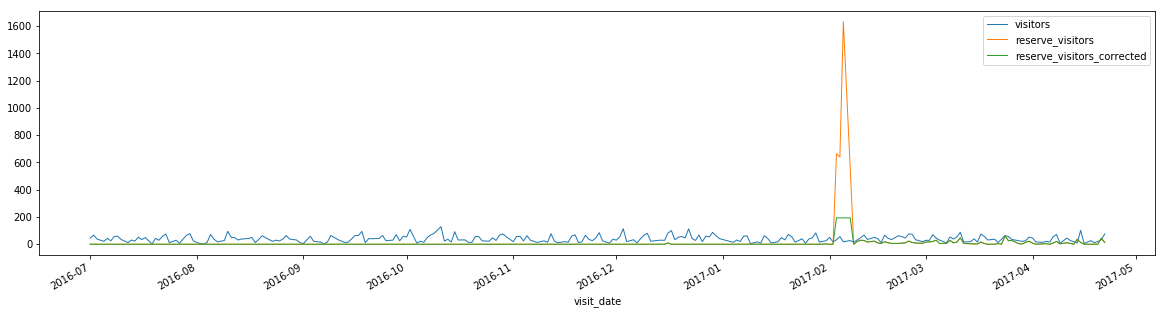

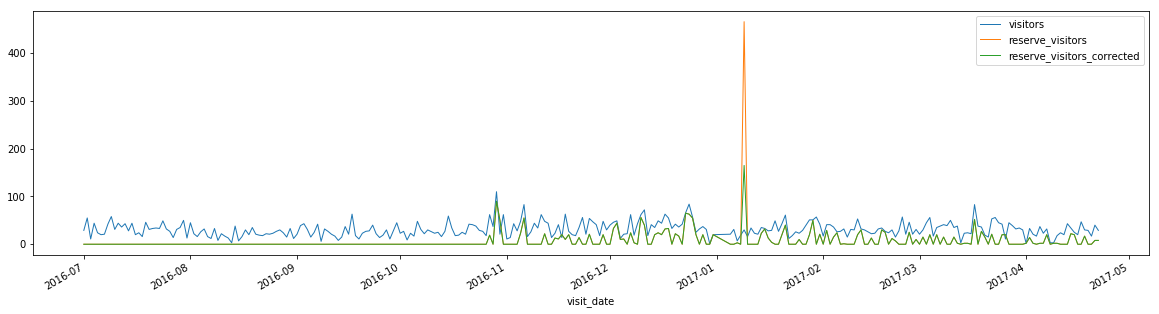

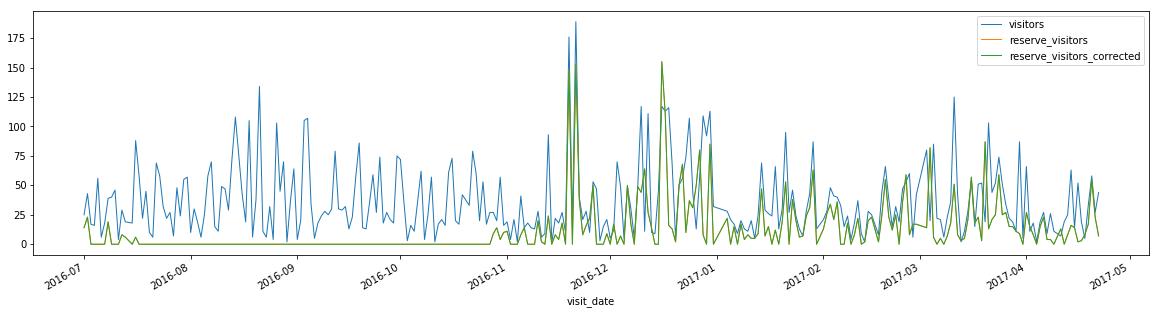

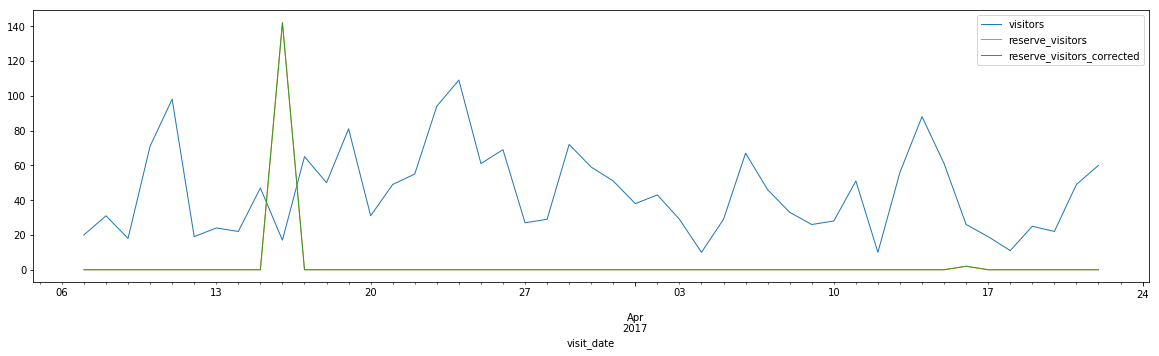

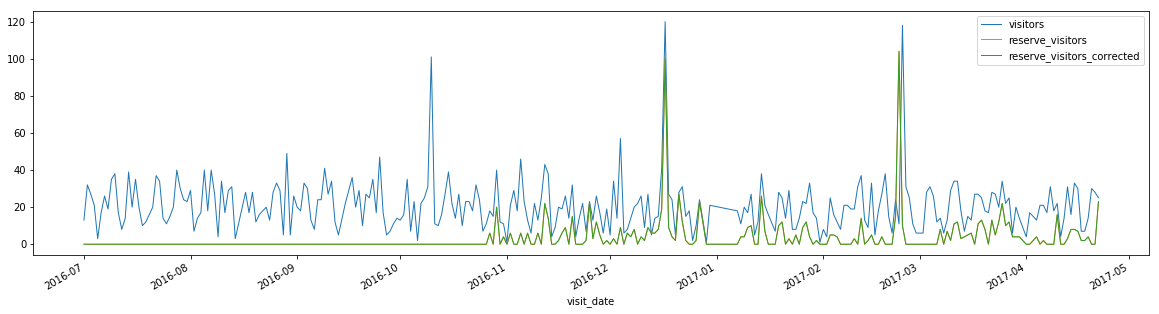

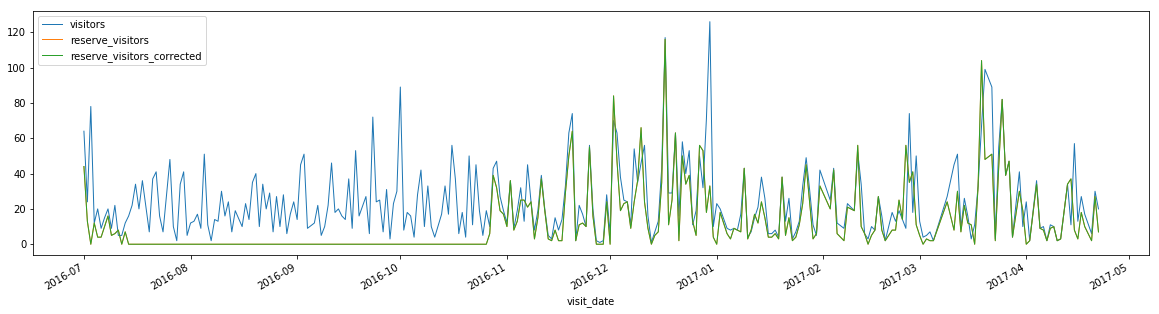

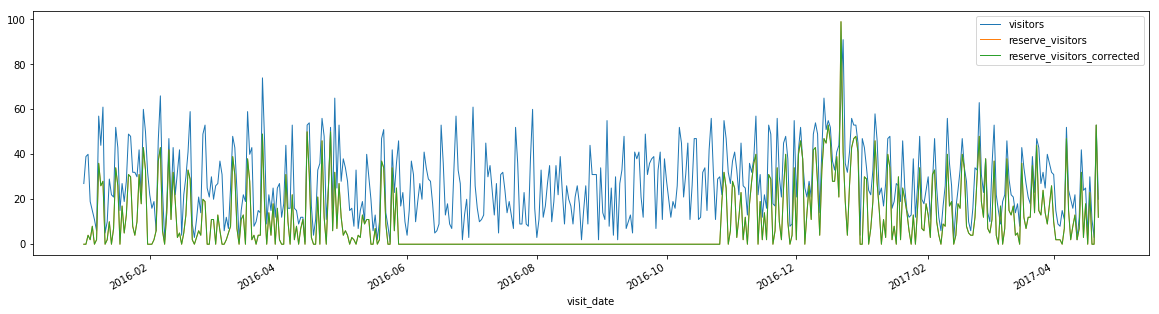

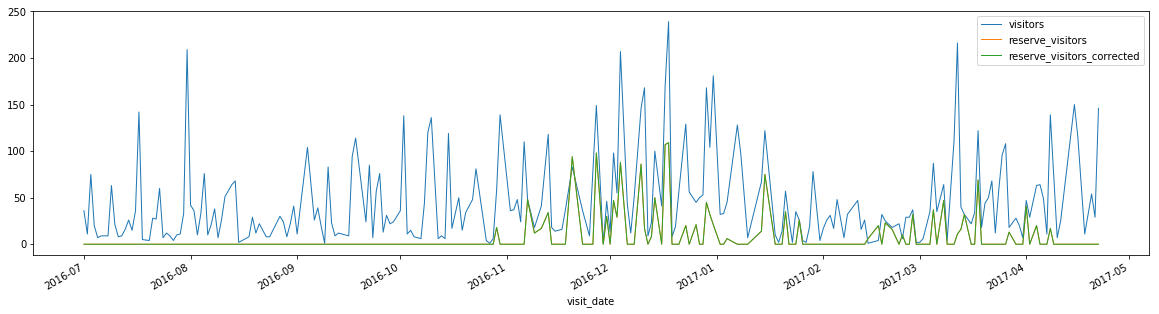

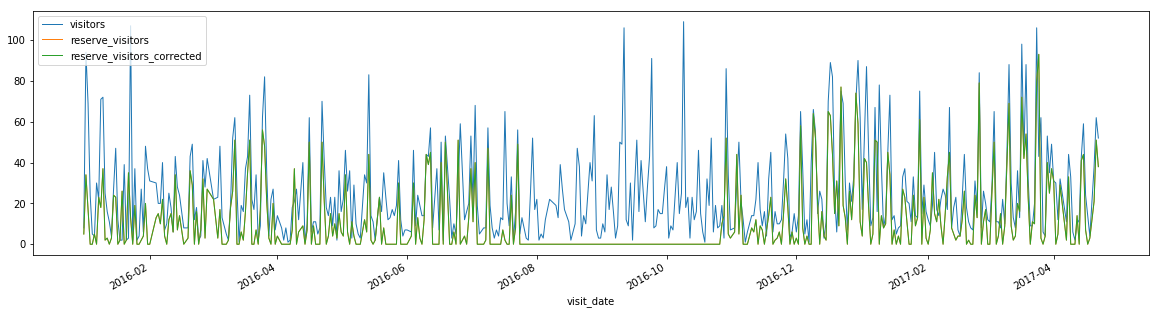

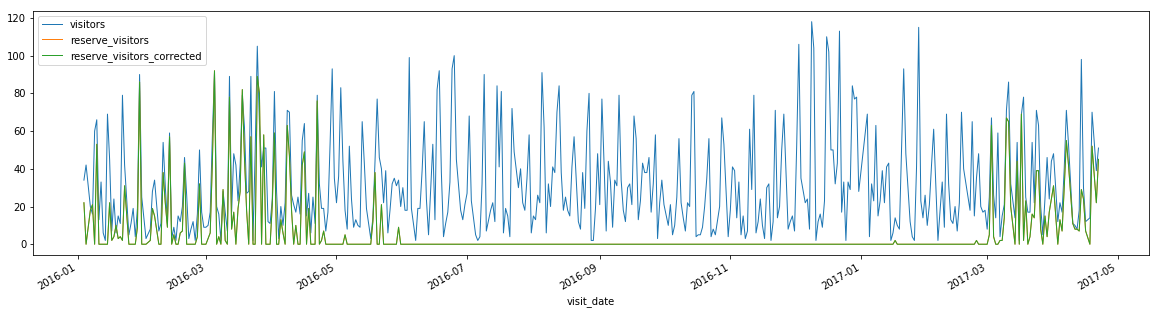

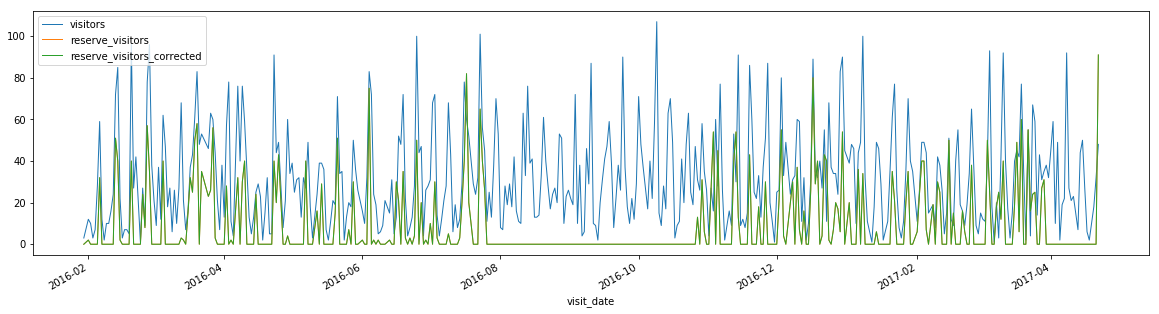

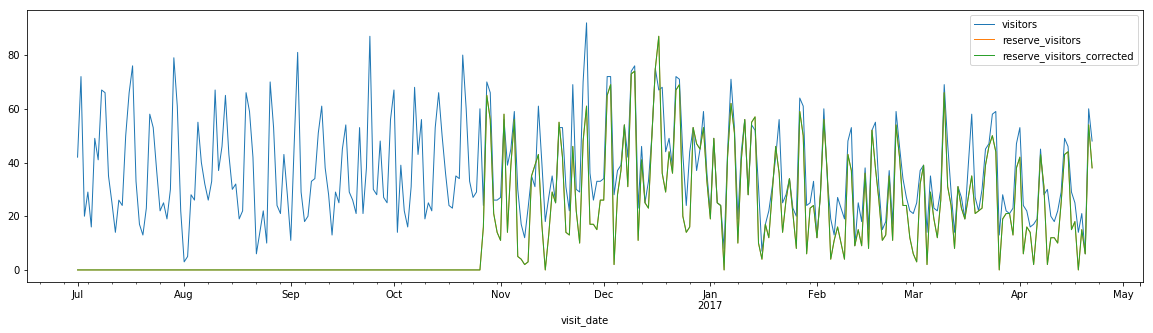

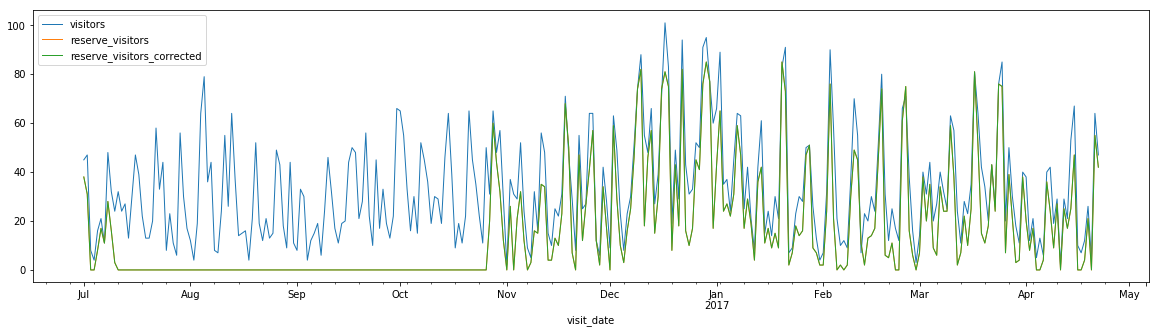

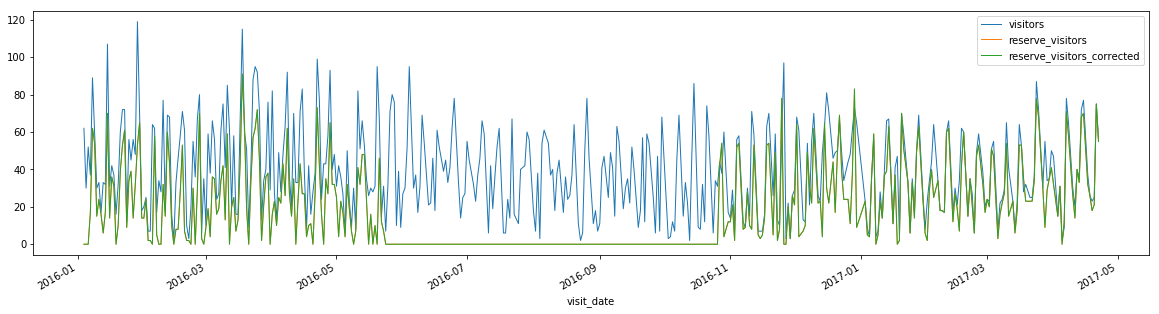

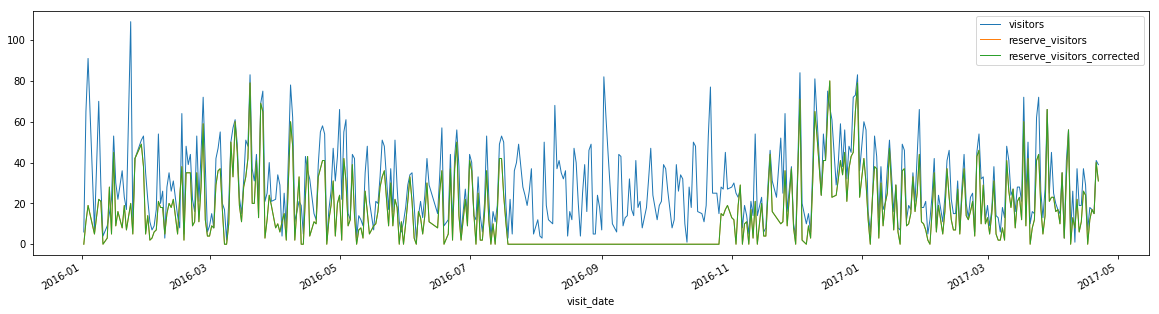

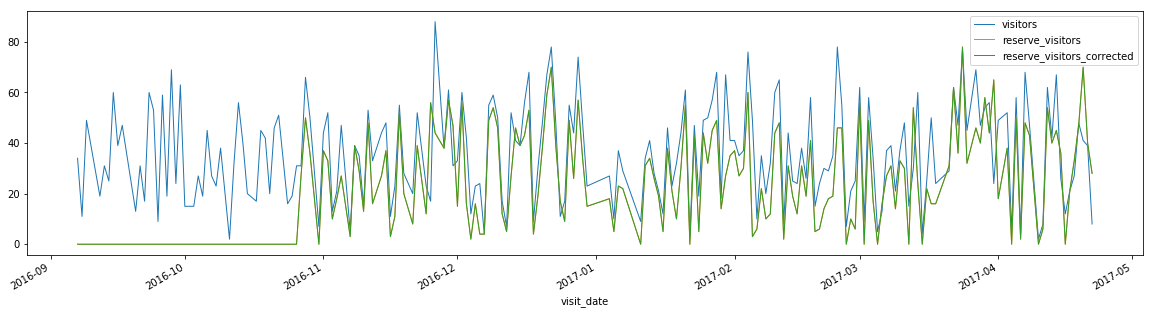

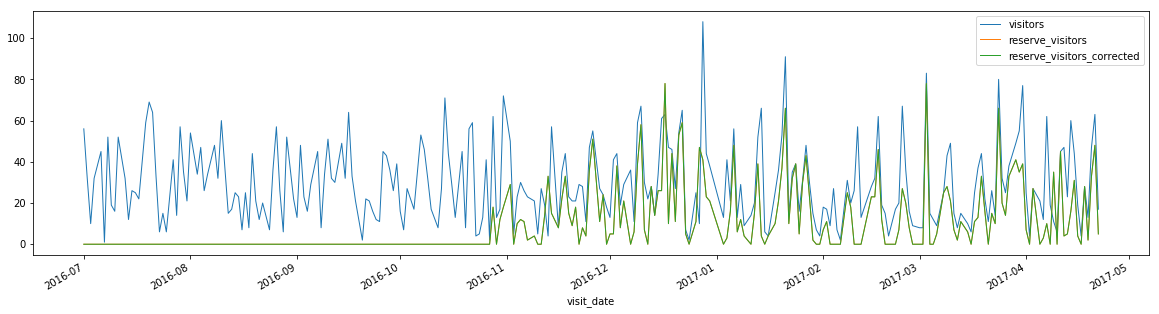

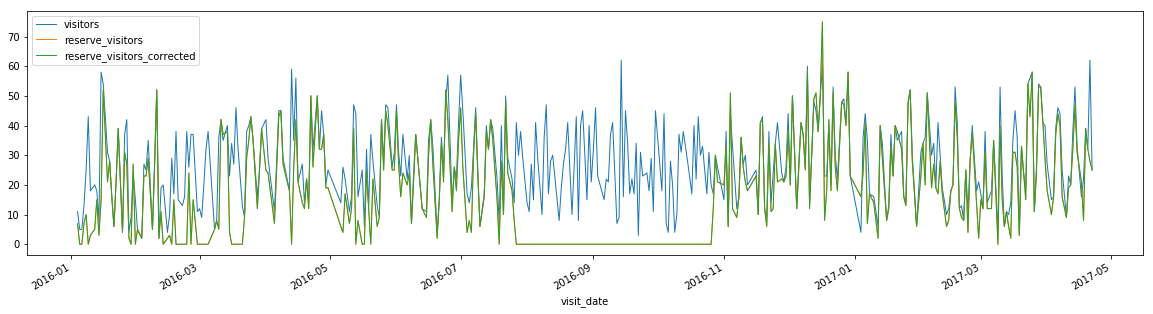

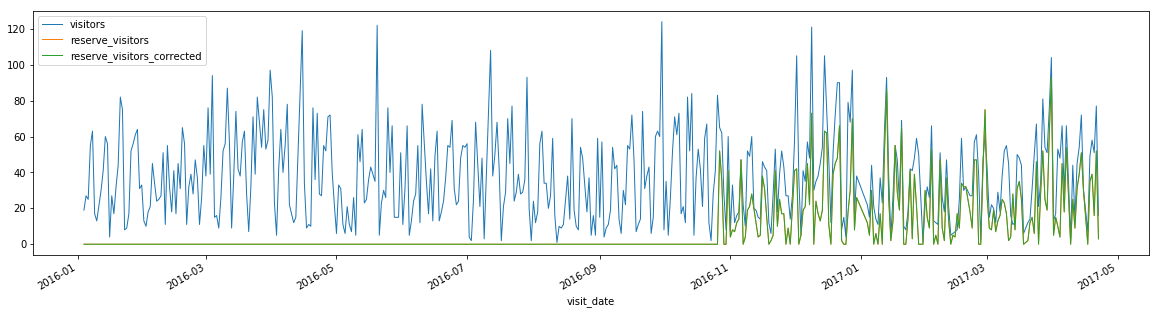

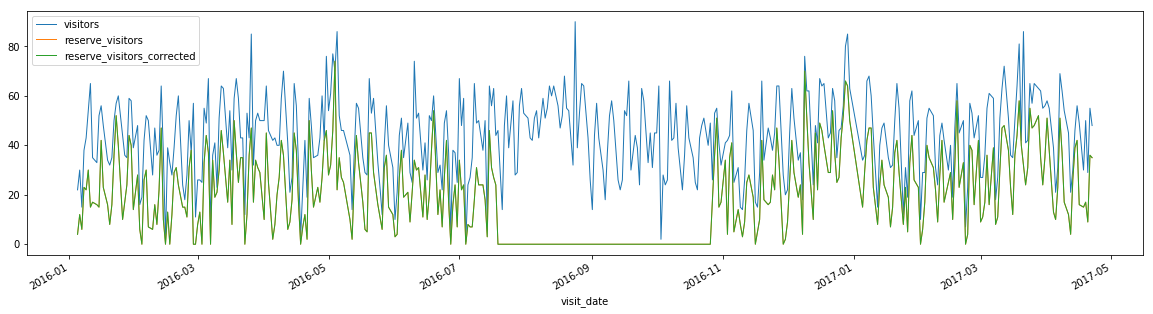

In [18]:
for location_id in air_visit_data[
        air_visit_data['reserve_visitors'] > air_visit_data['visitors']
    ].sort_values('reserve_visitors', ascending=False)['air_store_id'].unique()[:20]:
    air_visit_data[air_visit_data['air_store_id'] == location_id][[
        'visit_date',
        'visitors',
        'reserve_visitors',
        'reserve_visitors_corrected'
    ]].plot(
        kind='line',
        lw=1,
        figsize=(20, 5),
        x='visit_date'
    );
    plt.show()

In [19]:
desc(air_visit_data)

air_store_id visit_date  visitors  reserve_visitors  \
0  air_ba937bf13d40fb24 2016-01-13        25               0.0   
1  air_ba937bf13d40fb24 2016-01-14        32               0.0   
2  air_ba937bf13d40fb24 2016-01-15        29               0.0   
3  air_ba937bf13d40fb24 2016-01-16        22               0.0   
4  air_ba937bf13d40fb24 2016-01-18         6               0.0   

   reserve_visitors_corrected  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0

(252108, 5)
air_store_id                          object
visit_date                    datetime64[ns]
visitors                               int64
reserve_visitors                     float64
reserve_visitors_corrected           float64
dtype: object


# Feature extraction with TSFRESH

In [20]:
extracted_features = extract_features(
    air_visit_data[[
        'air_store_id',
        'visit_date',
        'visitors',
        'reserve_visitors_corrected'
    ]],
    column_id="air_store_id",
    column_sort="visit_date"
)

Feature Extraction: 100%|██████████| 20/20 [02:43<00:00,  8.18s/it]


In [21]:
extracted_features.shape

(829, 1588)

In [22]:
zero_variance_features = extracted_features.var().iloc[np.where(extracted_features.var() == 0)].index

In [23]:
len(zero_variance_features)

147

In [24]:
extracted_features = extracted_features[[col for col in extracted_features.columns if col not in zero_variance_features]]

In [25]:
extracted_features.shape

(829, 1441)

In [28]:
have_nulls_cols = extracted_features.columns[np.where(extracted_features.isnull().sum() > 0)]

In [29]:
len(have_nulls_cols)

797

In [30]:
extracted_features = extracted_features[[col for col in extracted_features.columns if col not in have_nulls_cols]]

In [31]:
extracted_features.shape

(829, 644)

In [32]:
extracted_features = impute(extracted_features)

In [33]:
extracted_features = pd.merge(
    left=extracted_features,
    right=air_store_info.set_index('air_store_id'),
    left_index=True,
    right_index=True,
    copy=False
)

In [34]:
genre_encoder = LabelEncoder()

extracted_features['air_genre_name'] = genre_encoder.fit_transform(extracted_features['air_genre_name'].values)

In [35]:
area_encoder = LabelEncoder()

extracted_features['air_area_name'] = genre_encoder.fit_transform(extracted_features['air_area_name'].values)

In [38]:
desc(extracted_features)

reserve_visitors_corrected__abs_energy  \
air_00a91d42b08b08d9                                   696.0   
air_0164b9927d20bcc3                                  4702.0   
air_0241aa3964b7f861                                     0.0   
air_0328696196e46f18                                     0.0   
air_034a3d5b40d5b1b1                                  2699.0   

                      reserve_visitors_corrected__absolute_sum_of_changes  \
air_00a91d42b08b08d9                                              140.0     
air_0164b9927d20bcc3                                              692.0     
air_0241aa3964b7f861                                                0.0     
air_0328696196e46f18                                                0.0     
air_034a3d5b40d5b1b1                                              186.0     

                      reserve_visitors_corrected__agg_autocorrelation__f_agg_"mean"  \
air_00a91d42b08b08d9                                          -0.001323               
air_0164b9927d20bcc3                                           0.001418               
air_0241aa3964b7f861                                           0.000000               
air_0328696196e46f18                                           0.000000               
air_034a3d5b40d5b1b1                                           0.002542               

                      reserve_visitors_corrected__agg_autocorrelation__f_agg_"median"  \
air_00a91d42b08b08d9                                          -0.028726                 
air_0164b9927d20bcc3                                           0.018042                 
air_0241aa3964b7f861                                           0.000000                 
air_0328696196e46f18                                           0.000000                 
air_034a3d5b40d5b1b1                                          -0.011999                 

                      reserve_visitors_corrected__agg_autocorrelation__f_agg_"var"  \
air_00a91d42b08b08d9                                           0.003204              
air_0164b9927d20bcc3                                           0.007735              
air_0241aa3964b7f861                                           0.000000              
air_0328696196e46f18                                           0.000000              
air_034a3d5b40d5b1b1                                           0.001388              

                      reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  \
air_00a91d42b08b08d9                                           0.173333                                           
air_0164b9927d20bcc3                                           5.950000                                           
air_0241aa3964b7f861                                           0.000000                                           
air_0328696196e46f18                                           0.000000                                           
air_034a3d5b40d5b1b1                                          -0.435897                                           

                      reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  \
air_00a91d42b08b08d9                                           0.296067                                        
air_0164b9927d20bcc3                                           0.539287                                        
air_0241aa3964b7f861                                           0.000000                                        
air_0328696196e46f18                                           0.000000                                        
air_034a3d5b40d5b1b1                                           0.221563                                        

                      reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"  \
air_00a91d42b08b08d9                                           0.198696                                       
air_0164b9927

(829, 648)
reserve_visitors_corrected__abs_energy                                                        float64
reserve_visitors_corrected__absolute_sum_of_changes                                           float64
reserve_visitors_corrected__agg_autocorrelation__f_agg_"mean"                                 float64
reserve_visitors_corrected__agg_autocorrelation__f_agg_"median"                               float64
reserve_visitors_corrected__agg_autocorrelation__f_agg_"var"                                  float64
reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"     float64
reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"        float64
reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"         float64
reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"        float64
reserve_visitors_corrected__agg_linear_trend__f_agg_"max"__chunk_len_5_

# Dimension reduction

## PCA, UMAP & TSNE

In [36]:
pca = PCA(n_components=2, random_state=42)
ump = umap.UMAP(n_neighbors=7, min_dist=0.01, random_state=42, metric='euclidean')
tsne = TSNE(n_components=2, random_state=42, perplexity=7, metric='euclidean')

X = extracted_features.values

pca_reduced = pca.fit_transform(X)
umap_reduced = ump.fit_transform(X)
tsne_reduced = tsne.fit_transform(X)

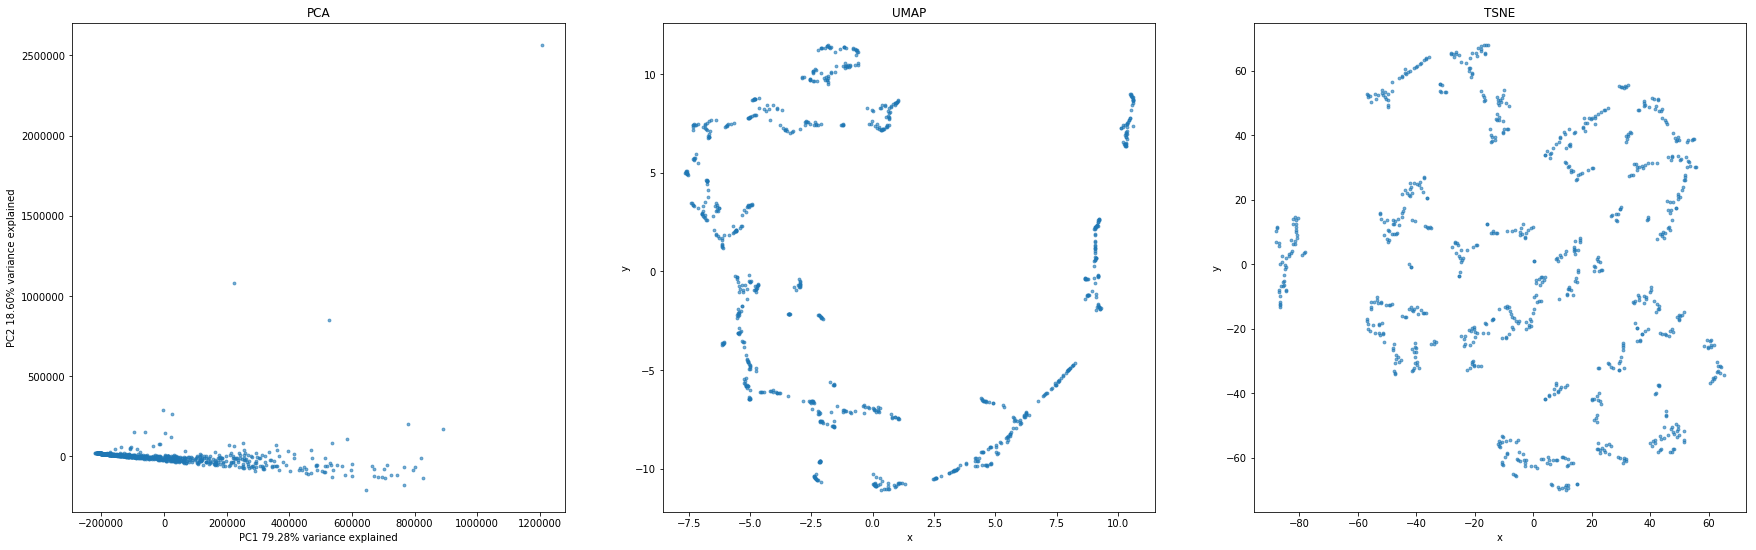

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 9));

pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    ax=axs[0],
    s=8,
    alpha=0.6,
    title='PCA'
);

pd.DataFrame(umap_reduced).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    ax=axs[1],
    s=8,
    alpha=0.6,
    title='UMAP'
);

pd.DataFrame(tsne_reduced).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    ax=axs[2],
    s=8,
    alpha=0.6,
    title='TSNE'
);

## Cluster in reduced dimensions

### PCA

In [103]:
sil_scores = []
X = pca_reduced

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(X);
    sil_score = silhouette_score(X, kmeans.predict(X))
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

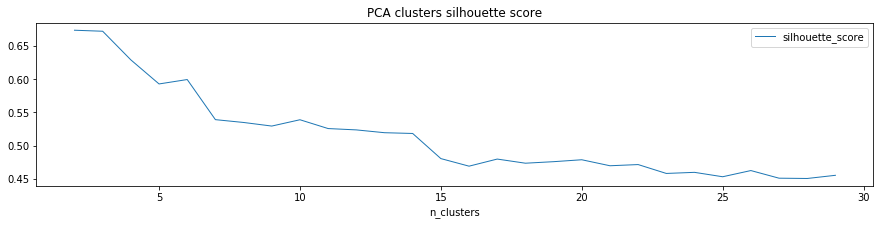

In [104]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 3),
    title='PCA clusters silhouette score'
);

In [105]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(5)

n_clusters  silhouette_score
0           2          0.673903
1           3          0.672376
2           4          0.629235
4           6          0.599625
3           5          0.592993

Choose `n_clusters == 2`

In [106]:
kmeans = KMeans(n_clusters=2, random_state=42)
pca_clusters = kmeans.fit_predict(X)

### UMAP

In [88]:
sil_scores = []
X = umap_reduced

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(X);
    sil_score = silhouette_score(X, kmeans.predict(X))
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

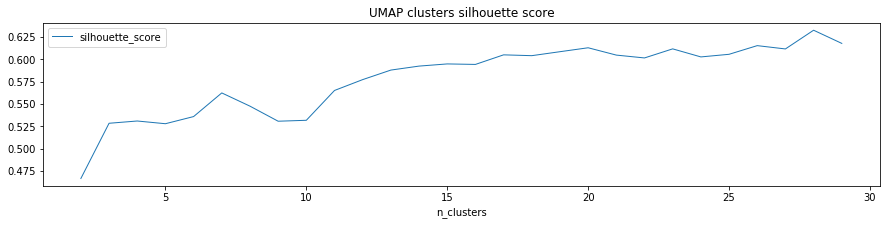

In [94]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 3),
    title='UMAP clusters silhouette score'
);

In [95]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(5)

n_clusters  silhouette_score
26          28          0.632478
27          29          0.617768
24          26          0.615251
18          20          0.612865
21          23          0.611638

Choose `n_clusters == 20`

In [101]:
kmeans = KMeans(n_clusters=20, random_state=42)
umap_clusters = kmeans.fit_predict(X)

### TSNE

In [97]:
sil_scores = []
X = tsne_reduced

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(X);
    sil_score = silhouette_score(X, kmeans.predict(X))
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

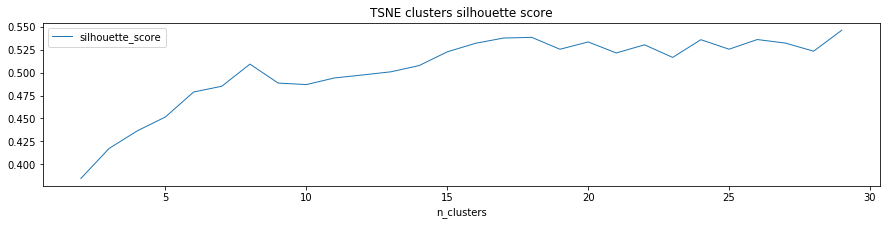

In [98]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 3),
    title='TSNE clusters silhouette score'
);

In [99]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(5)

n_clusters  silhouette_score
27          29          0.546425
16          18          0.538629
15          17          0.537887
24          26          0.536240
22          24          0.536084

Choose `n_clusters == 17`

In [100]:
kmeans = KMeans(n_clusters=17, random_state=42)
tsne_clusters = kmeans.fit_predict(X)

### Plot

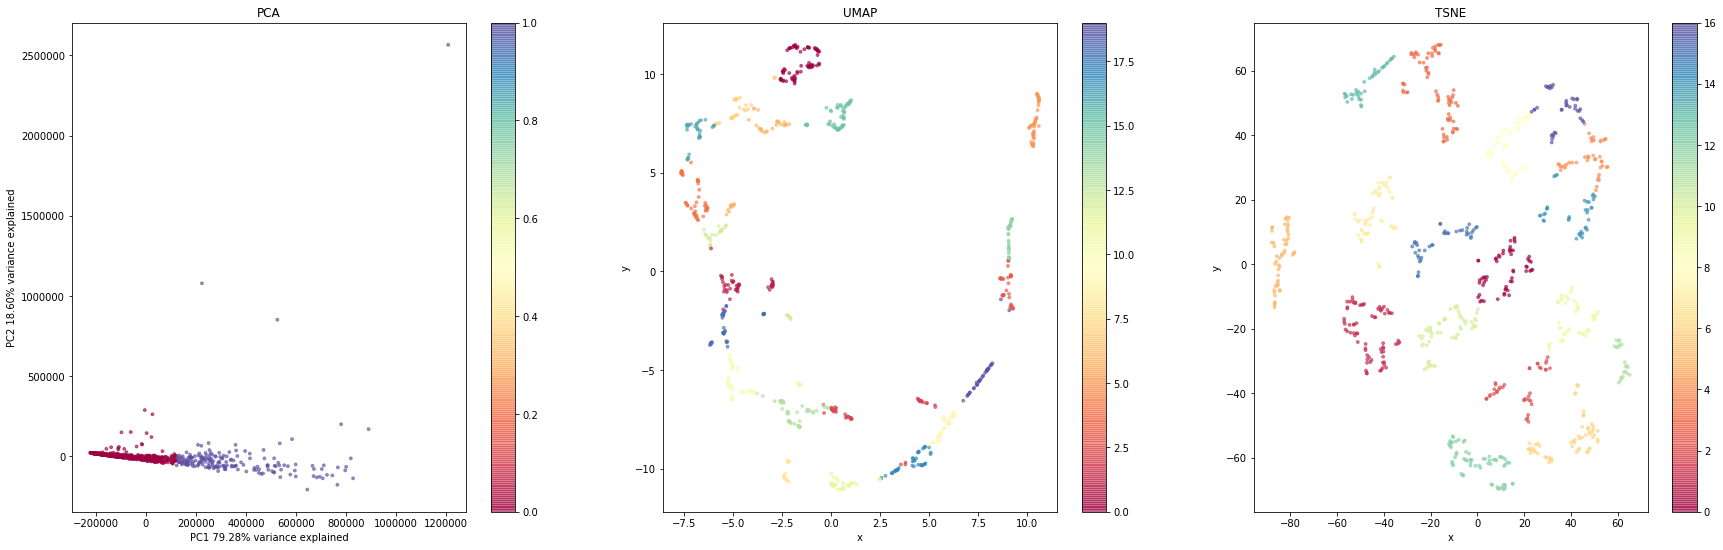

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 9));

pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    ax=axs[0],
    s=8,
    alpha=0.6,
    title='PCA',
    c=pca_clusters,
    cmap='Spectral'
);

pd.DataFrame(umap_reduced).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    ax=axs[1],
    s=8,
    alpha=0.6,
    title='UMAP',
    c=umap_clusters,
    cmap='Spectral'
);

pd.DataFrame(tsne_reduced).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    ax=axs[2],
    s=8,
    alpha=0.6,
    title='TSNE',
    c=tsne_clusters,
    cmap='Spectral'
);

# Outlier detection: Isolation forests

In [85]:
isof = IsolationForest(
    n_estimators=500,
    contamination=0.1,
    max_features=1.0,
    random_state=42
)

# pca
isof.fit(pca_reduced)
pca_outliers = isof.predict(pca_reduced)

# umap
isof.fit(umap_reduced)
umap_outliers = isof.predict(umap_reduced)

# tsne
isof.fit(tsne_reduced)
tsne_outliers = isof.predict(tsne_reduced)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=1, random_state=42,
        verbose=0)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=1, random_state=42,
        verbose=0)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=1, random_state=42,
        verbose=0)

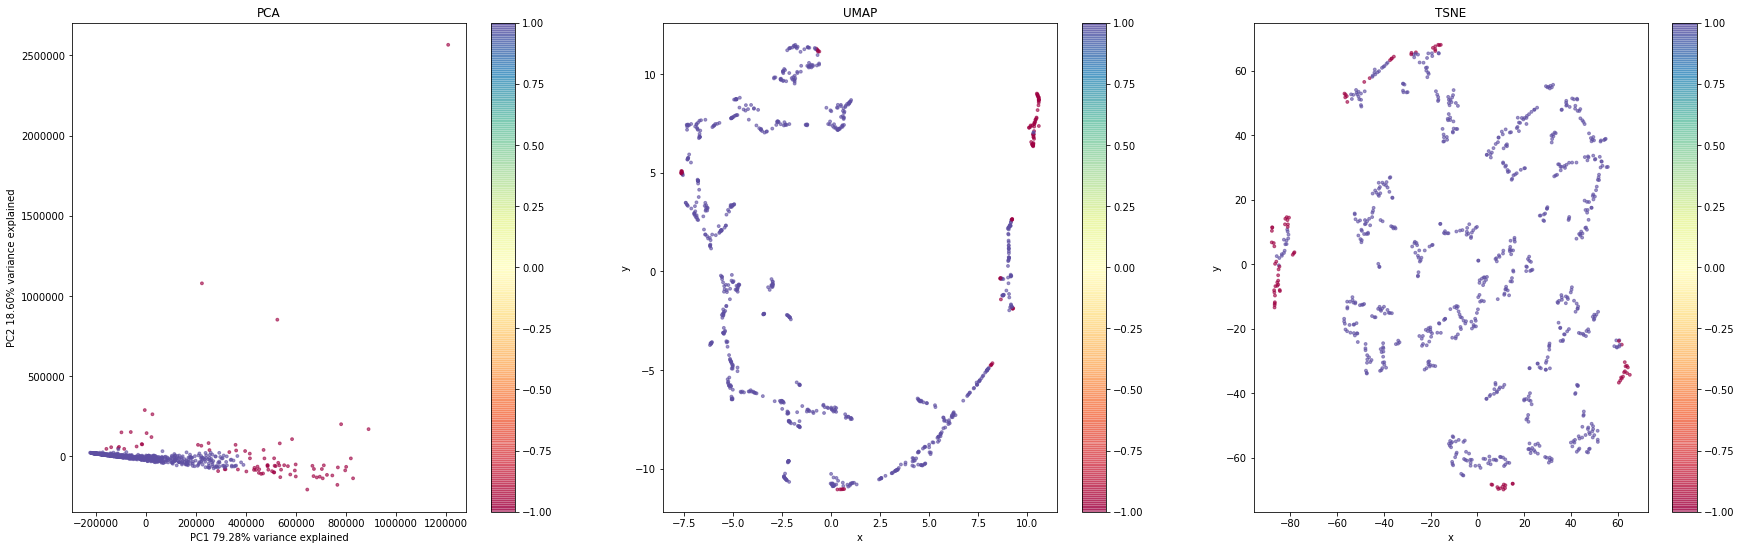

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 9));

pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    ax=axs[0],
    s=8,
    alpha=0.6,
    title='PCA',
    c=pca_outliers,
    cmap='Spectral'
);

pd.DataFrame(umap_reduced).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    ax=axs[1],
    s=8,
    alpha=0.6,
    title='UMAP',
    c=umap_outliers,
    cmap='Spectral'
);

pd.DataFrame(tsne_reduced).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    ax=axs[2],
    s=8,
    alpha=0.6,
    title='TSNE',
    c=tsne_outliers,
    cmap='Spectral'
);